In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
df_ajustado = pd.read_csv('Datos/Transformados/limpio.csv')

**Cambios al dia**

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_35756\3640970676.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


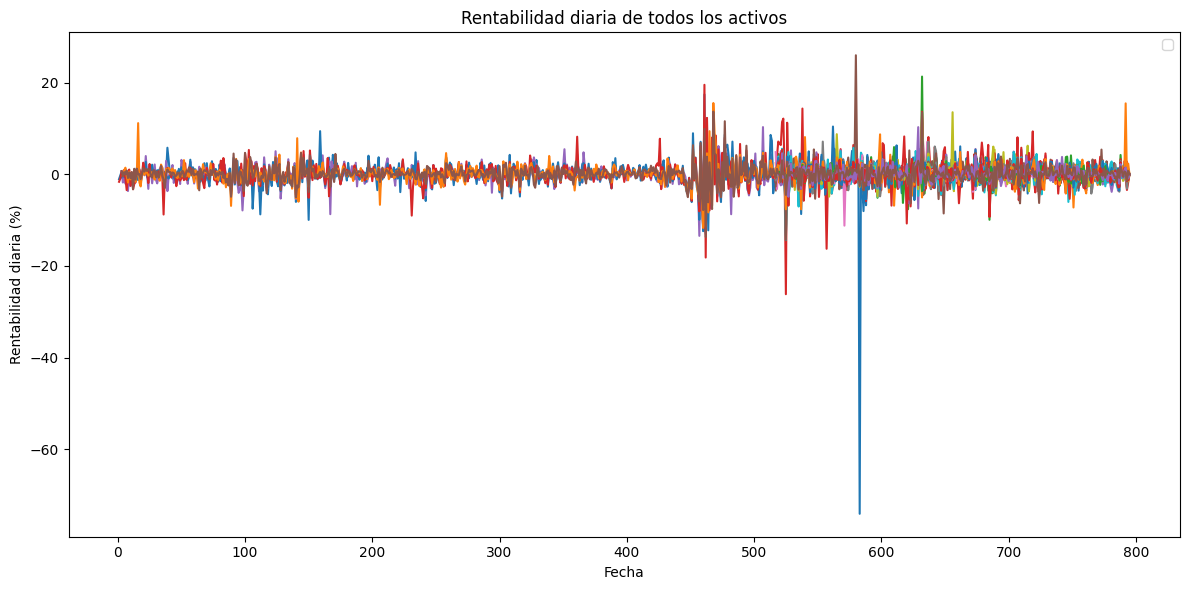

In [3]:
rentabilidades_diarias = df_ajustado.pct_change() * 100
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, rentabilidades_diarias[col])
plt.title('Rentabilidad diaria de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad diaria (%)')
plt.legend()
plt.tight_layout()
plt.show()

Define la función de **rentabilidad anualizada**:
$r_{periodo} = (1+r)^n -1$

In [4]:
def rentabilidad_anualizada(r_diaria, n=252):
    return (np.prod(1 + r_diaria) ** (n / len(r_diaria))) - 1

In [5]:
resultados = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    rent_diaria = rentabilidades_diarias[col].loc[serie.index].dropna()
    if len(serie) > 1 and len(rent_diaria) > 0:
        rent_media = rent_diaria.mean()
        rent_activa = (serie.iloc[-1] - serie.iloc[0]) / serie.iloc[0]
        r_diaria_decimal = rent_diaria / 100
        rent_anual = rentabilidad_anualizada(r_diaria_decimal, 252)
        resultados[col] = {
            'Rentabilidad media (%)': rent_media,
            'Rentabilidad activa (%)': rent_activa*100,
            'Rentabilidad anualizada (%)': rent_anual*100}
    else:
        resultados[col] = {'Rentabilidad media (%)': np.nan, 'Rentabilidad activa (%)': np.nan, 'Rentabilidad anualizada (%)': np.nan}
df_resultados = pd.DataFrame(resultados).T
df_resultados

,Rentabilidad media (%),Rentabilidad activa (%),Rentabilidad anualizada (%)
AAPL,0.055761,-29.545220,-10.506707
AMGN,0.040064,8.178289,7.358449
AXP,0.212686,67.499490,59.343651
BA,0.226436,57.362168,50.607105
CAT,0.063510,37.575951,10.669035
CRM,0.139491,35.731640,31.777417
CSCO,0.066215,16.043426,14.384437
CVX,0.073069,14.185100,12.728656
DIS,0.163405,48.976445,43.338974
DOW,0.206786,64.309940,56.600500


In [6]:
vol_diaria = rentabilidades_diarias.std()
vol_anual = vol_diaria * np.sqrt(252)
df_volatilidad = pd.DataFrame({'Volatilidad diaria': vol_diaria, 'Volatilidad anualizada': vol_anual})
df_volatilidad

,Volatilidad diaria,Volatilidad anualizada
AAPL,3.391876,53.844367
AMGN,1.545021,24.526440
AXP,2.382673,37.823762
BA,3.541397,56.217939
CAT,2.152289,34.166523
CRM,2.516525,39.948602
CSCO,1.593774,25.300377
CVX,2.258873,35.858502
DIS,2.046576,32.488392
DOW,2.384944,37.859810


**Volatilidad anualizada**: $\sigma*\sqrt(n)$

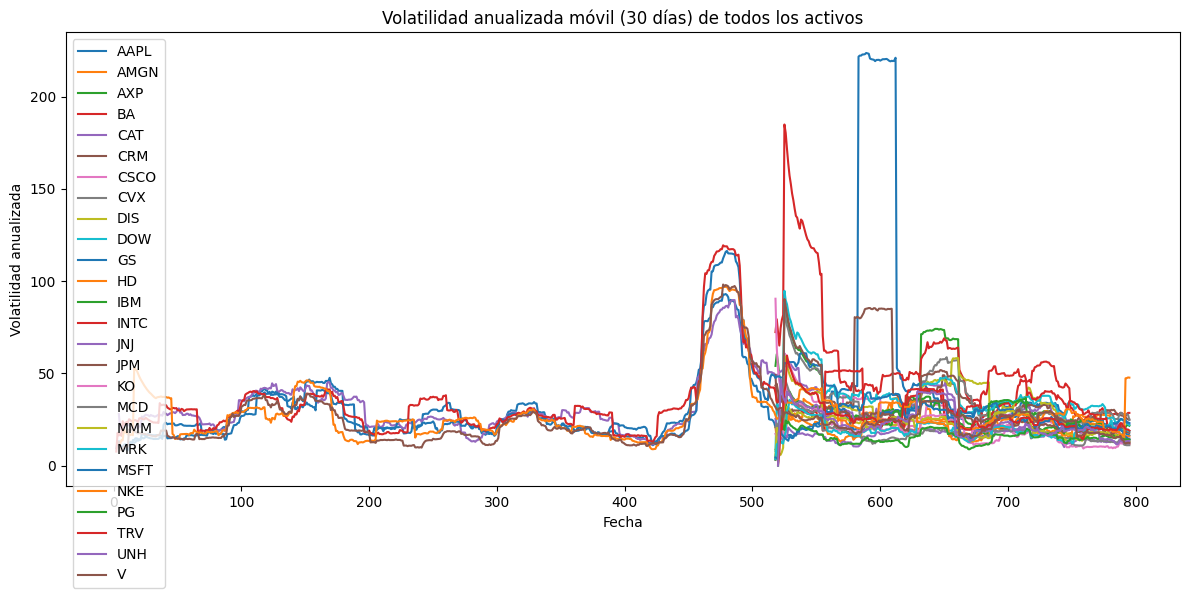

In [7]:
vol_30d = rentabilidades_diarias.rolling(window=30, min_periods=1).std() * np.sqrt(252)
plt.figure(figsize=(12,6))
for col in df_ajustado.columns:
    plt.plot(df_ajustado.index, vol_30d[col], label=col)
plt.title('Volatilidad anualizada móvil (30 días) de todos los activos')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad anualizada')
plt.legend()
plt.tight_layout()
plt.show()

**Ratio de Sharpe**: $S_h = \frac{r-r_f}{\sigma}$

In [8]:
rf = 0.025
sharpe = {}
for col in df_ajustado.columns:
    vol_anual_col = vol_anual[col] if col in vol_anual else np.nan
    rent_anual_col = df_resultados.loc[col, 'Rentabilidad anualizada (%)'] if col in df_resultados.index else np.nan
    if not np.isnan(vol_anual_col) and not np.isnan(rent_anual_col) and vol_anual_col != 0:
        sharpe[col] = (rent_anual_col/100 - rf) / vol_anual_col
    else:
        sharpe[col] = np.nan
df_sharpe = pd.DataFrame({'Sharpe': sharpe})
df_sharpe

,Sharpe
AAPL,-0.002416
AMGN,0.001981
AXP,0.015029
BA,0.008557
CAT,0.002391
CRM,0.007329
CSCO,0.004697
CVX,0.002853
DIS,0.012570
DOW,0.014290


$Drawdown_i = \frac{p_i}{p_{max}}$

$Max-drawdown = min(drawdown_i)_n$

In [9]:
max_drawdown = {}
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        drawdown = serie / max_close - 1
        max_drawdown[col] = drawdown.min()
    else:
        max_drawdown[col] = np.nan
df_drawdown = pd.DataFrame({'Max Drawdown': max_drawdown})
df_drawdown

,Max Drawdown
AAPL,-0.788891
AMGN,-0.170799
AXP,-0.203220
BA,-0.373579
CAT,-0.419463
CRM,-0.269938
CSCO,-0.258467
CVX,-0.352189
DIS,-0.161656
DOW,-0.162309


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_35756\348396274.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


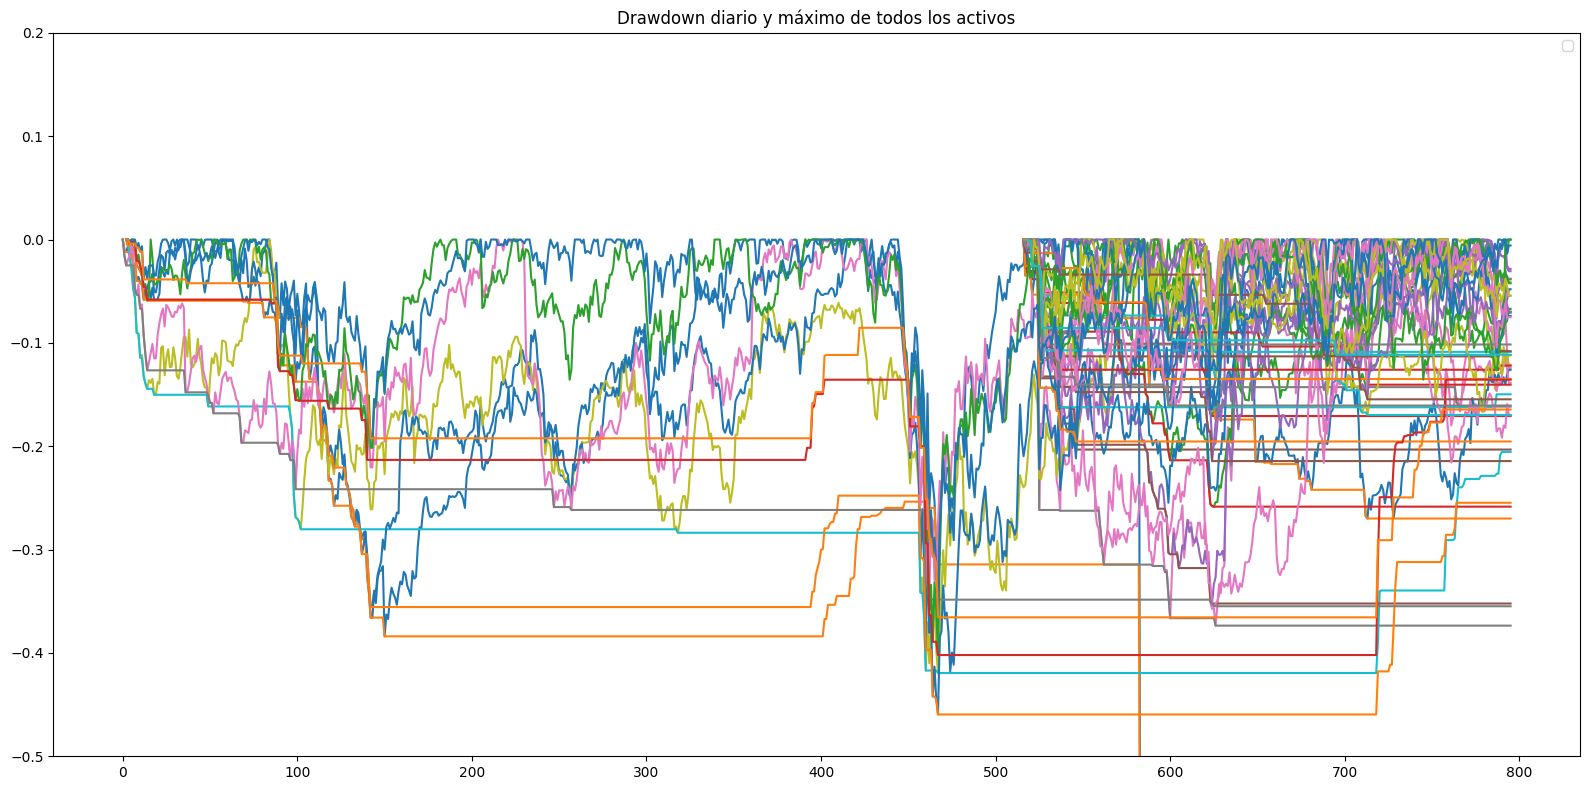

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
for col in df_ajustado.columns:
    serie = df_ajustado[col].dropna()
    if len(serie) > 1:
        max_close = serie.cummax()
        daily_drawdown = serie / max_close - 1
        max_daily_drawdown = daily_drawdown.rolling(window=252, min_periods=1).min()
        ax.plot(serie.index, daily_drawdown)
        ax.plot(serie.index, max_daily_drawdown)
ax.set_ylim(-0.5, 0.2)
ax.legend()
plt.title('Drawdown diario y máximo de todos los activos')
plt.tight_layout()
plt.show()